In [1]:
pip install -U tensorflow-addons

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: E:\DL\soil_detection\venv_soil\Scripts\python.exe -m pip install --upgrade pip


In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: E:\DL\soil_detection\venv_soil\Scripts\python.exe -m pip install --upgrade pip


In [3]:
#pip install opencv-python
!pip install pandas

In [4]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt
import cv2

import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

E:\DL\soil_detection\venv_soil\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
# from google.colab import drive
# drive.mount("/content/drive")

In [24]:
import tensorflow as tf
import os
gpus = tf.config.experimental.list_physical_devices('GPU')
len(gpus)

0

In [25]:
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)


In [5]:
# Loading images for dataset
data = tf.keras.utils.image_dataset_from_directory('C:/Users/brainart/Music/computer_vision/tomato_swin/data_swin_old', image_size=(32, 32)) 

Found 9000 files belonging to 3 classes.


In [6]:
data = data.map(lambda x, y: (x/255, y))

In [10]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()


In [ ]:
batch[0][1].max()

In [7]:
# Merge all batches in single arrays
import numpy as np
import sklearn

x_batches = []
y_batches = []
for batch in data.as_numpy_iterator():
  # Concatenate the batches along the first axis
  x_batches.append(batch[0])
  y_batches.append(batch[1])
x_array = np.concatenate(x_batches, axis=0)
y_array = np.concatenate(y_batches, axis=0)

In [8]:
#!pip install sklearn

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_array, y_array, test_size=0.2, random_state=42)

In [10]:
x_train.max()

1.0

**Prepare the data**

x_train shape: (7200, 32, 32, 3) - y_train shape: (7200, 3)
x_test shape: (1800, 32, 32, 3) - y_test shape: (1800, 3)


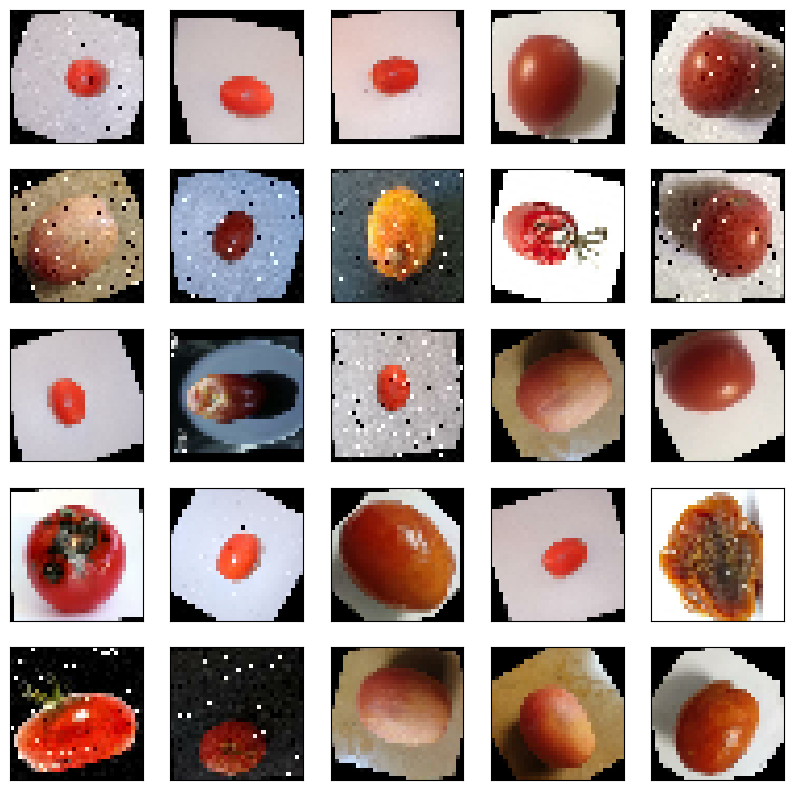

In [11]:
num_classes = 3
input_shape = (32, 32, 3)

#(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

#print(x_test.shape)

#x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
plt.show()



**Configure the hyperparameters**

In [12]:
patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 32  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 128
num_epochs = 200
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

**Helper functions**

In [13]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output

**Windows based multi-head self-attention**

In [14]:
class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super().__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv

**The complete Swin Transformer model**

In [15]:
class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x

**Model training and evaluation**

In [16]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super().__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)

**Build the model**

Let's put together the Swin Transformer model.

In [17]:
input = layers.Input(input_shape)
x = layers.RandomCrop(image_dimension, image_dimension)(input)
x = layers.RandomFlip("horizontal")(x)
x = PatchExtract(patch_size)(x)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)

**Train on Tomato swin Dataset 32*32 **

In [18]:
# from keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime

model = keras.Model(input, output)
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        keras.metrics.Precision(name="Precision"),
        keras.metrics.Recall(name="Recall"),
        #keras.metrics.F1Score(num_classes=3, name="F1Score"),
    ],
)


# keeping track of runtime
start = datetime.now()


history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=validation_split,
)

# keeping track of runtime
duration = datetime.now() - start 
print("Training completed in Time: ", duration)

MODEL_NAME = 'tomato_swin_may17b'
# save the trained model
#model.save(f'{MODEL_NAME}.h5')
#keras.models.save_model(model, 'C:/Users/brainart/Music/computer_vision/soil_texture/soil_swin_aprilb.h5')
#keras.models.save_model(model, 'C:/Users/brainart/Music/computer_vision/soil_texture/soil_swin_aprilb.hdf5')

Epoch 1/200
51/51 [==============================] - 110s 2s/step - loss: 1.2176 - accuracy: 0.4650 - top-5-accuracy: 1.0000 - Precision: 0.5041 - Recall: 0.2651 - val_loss: 0.8841 - val_accuracy: 0.6653 - val_top-5-accuracy: 1.0000 - val_Precision: 0.6778 - val_Recall: 0.4236
Epoch 2/200
51/51 [==============================] - 81s 2s/step - loss: 0.8068 - accuracy: 0.6940 - top-5-accuracy: 1.0000 - Precision: 0.7371 - Recall: 0.5633 - val_loss: 0.7441 - val_accuracy: 0.7222 - val_top-5-accuracy: 1.0000 - val_Precision: 0.7563 - val_Recall: 0.6722
Epoch 3/200
51/51 [==============================] - 78s 2s/step - loss: 0.6767 - accuracy: 0.7704 - top-5-accuracy: 1.0000 - Precision: 0.8124 - Recall: 0.6995 - val_loss: 0.6119 - val_accuracy: 0.8250 - val_top-5-accuracy: 1.0000 - val_Precision: 0.8471 - val_Recall: 0.7847
Epoch 4/200
51/51 [==============================] - 80s 2s/step - loss: 0.5900 - accuracy: 0.8412 - top-5-accuracy: 1.0000 - Precision: 0.8727 - Recall: 0.7957 - val_l

51/51 [==============================] - 78s 2s/step - loss: 0.3279 - accuracy: 0.9887 - top-5-accuracy: 1.0000 - Precision: 0.9915 - Recall: 0.9855 - val_loss: 0.3390 - val_accuracy: 0.9792 - val_top-5-accuracy: 1.0000 - val_Precision: 0.9805 - val_Recall: 0.9764
Epoch 60/200
51/51 [==============================] - 79s 2s/step - loss: 0.3278 - accuracy: 0.9897 - top-5-accuracy: 1.0000 - Precision: 0.9933 - Recall: 0.9869 - val_loss: 0.3449 - val_accuracy: 0.9833 - val_top-5-accuracy: 1.0000 - val_Precision: 0.9846 - val_Recall: 0.9764
Epoch 61/200
51/51 [==============================] - 80s 2s/step - loss: 0.3386 - accuracy: 0.9863 - top-5-accuracy: 1.0000 - Precision: 0.9894 - Recall: 0.9821 - val_loss: 0.3372 - val_accuracy: 0.9833 - val_top-5-accuracy: 1.0000 - val_Precision: 0.9861 - val_Recall: 0.9819
Epoch 62/200
51/51 [==============================] - 79s 2s/step - loss: 0.3252 - accuracy: 0.9917 - top-5-accuracy: 1.0000 - Precision: 0.9921 - Recall: 0.9897 - val_loss: 0.334

51/51 [==============================] - 91s 2s/step - loss: 0.3180 - accuracy: 0.9940 - top-5-accuracy: 1.0000 - Precision: 0.9952 - Recall: 0.9924 - val_loss: 0.3428 - val_accuracy: 0.9806 - val_top-5-accuracy: 1.0000 - val_Precision: 0.9873 - val_Recall: 0.9736
Epoch 118/200
51/51 [==============================] - 90s 2s/step - loss: 0.3146 - accuracy: 0.9954 - top-5-accuracy: 1.0000 - Precision: 0.9968 - Recall: 0.9940 - val_loss: 0.3278 - val_accuracy: 0.9917 - val_top-5-accuracy: 1.0000 - val_Precision: 0.9916 - val_Recall: 0.9889
Epoch 119/200
51/51 [==============================] - 91s 2s/step - loss: 0.3151 - accuracy: 0.9963 - top-5-accuracy: 1.0000 - Precision: 0.9967 - Recall: 0.9937 - val_loss: 0.3273 - val_accuracy: 0.9875 - val_top-5-accuracy: 1.0000 - val_Precision: 0.9958 - val_Recall: 0.9861
Epoch 120/200
51/51 [==============================] - 91s 2s/step - loss: 0.3161 - accuracy: 0.9957 - top-5-accuracy: 1.0000 - Precision: 0.9966 - Recall: 0.9944 - val_loss: 0.

51/51 [==============================] - 83s 2s/step - loss: 0.3247 - accuracy: 0.9903 - top-5-accuracy: 1.0000 - Precision: 0.9919 - Recall: 0.9880 - val_loss: 0.3497 - val_accuracy: 0.9819 - val_top-5-accuracy: 1.0000 - val_Precision: 0.9833 - val_Recall: 0.9819
Epoch 176/200
51/51 [==============================] - 83s 2s/step - loss: 0.3323 - accuracy: 0.9906 - top-5-accuracy: 1.0000 - Precision: 0.9932 - Recall: 0.9887 - val_loss: 0.3244 - val_accuracy: 0.9889 - val_top-5-accuracy: 1.0000 - val_Precision: 0.9903 - val_Recall: 0.9889
Epoch 177/200
51/51 [==============================] - 81s 2s/step - loss: 0.3136 - accuracy: 0.9957 - top-5-accuracy: 1.0000 - Precision: 0.9961 - Recall: 0.9938 - val_loss: 0.3199 - val_accuracy: 0.9958 - val_top-5-accuracy: 1.0000 - val_Precision: 0.9972 - val_Recall: 0.9931
Epoch 178/200
51/51 [==============================] - 83s 2s/step - loss: 0.3115 - accuracy: 0.9969 - top-5-accuracy: 1.0000 - Precision: 0.9978 - Recall: 0.9951 - val_loss: 0.

In [1]:
# tf.keras.models.save_model(model, 'C:/Users/brainart/Music/computer_vision/tomato_swin/tomato_swin_may17.h5')

Let's visualize the training progress of the model.

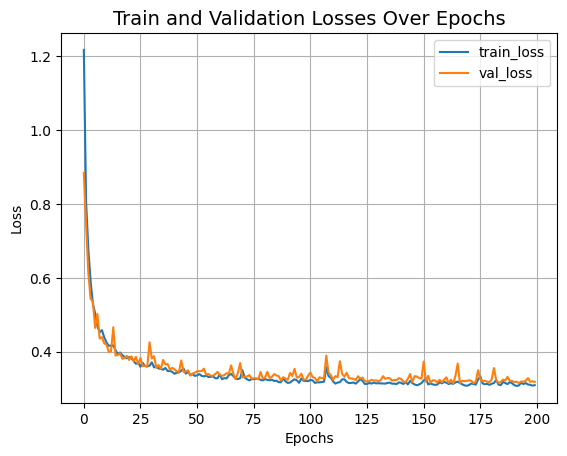

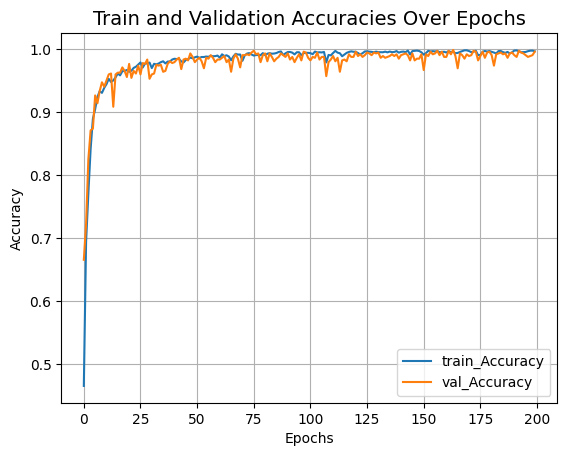

In [19]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

plt.plot(history.history["accuracy"], label="train_Accuracy")
plt.plot(history.history["val_accuracy"], label="val_Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracies Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

Let's display the final results of the training on Tomato Dataset.

In [20]:
loss, accuracy, top_5_accuracy, precision, recall = model.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test Precision: {round(precision * 100, 2)}%")
print(f"Test Recall: {round(recall * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

57/57 [==============================] - 6s 109ms/step - loss: 0.3140 - accuracy: 0.9956 - top-5-accuracy: 1.0000 - Precision: 0.9967 - Recall: 0.9939
Test loss: 0.31
Test accuracy: 99.56%
Test Precision: 99.67%
Test Recall: 99.39%
Test top 5 accuracy: 100.0%


In [21]:
len(x_test)

1800

1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 66ms/step


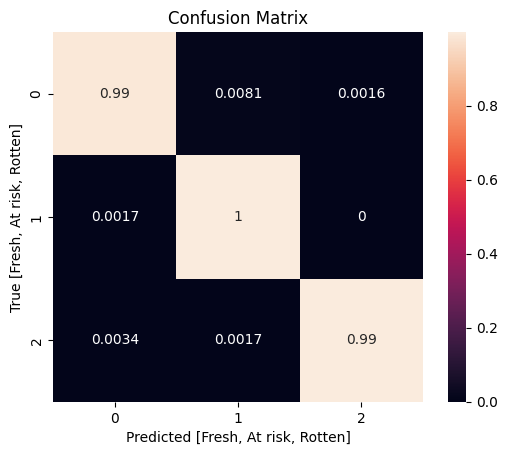

In [22]:
# Display Confusion Matrix
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_names = ['Fresh', 'At risk', 'Rotten'] 

#x_tests = x_test.reshape(32, 32, 32, 3)

# Make predictions on the test set
y_pred = []
for i in range(len(x_test)):
    img_batch = np.expand_dims(x_test[i], axis =0)
    prediction_array = model.predict(img_batch)[0]
    first_idx = np.argmax(prediction_array)
    first_class = class_names[first_idx]
    
    #predic = model.predict(x_tests[i])
    #predic = predic.argmax(axis=1)
    #prediction_array = prediction_array.argmax(axis=0)
    y_pred.append(first_idx)

#y_test = y_test.argmax(axis=1)
# Convert probabilities to class predictions
#y_pred = predicted_labels.argmax(axis=1)

# Generate classification report
#target_names = list(test_generator.class_indices.keys())
#report = classification_report(y_test, y_pred, target_names=class_names)

# Print classification report
#print(report)

y_test = y_test.argmax(axis=1)
# Compute the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(confusion_mat,annot=True)

# Display the confusion matrix
plt.imshow(confusion_mat)
plt.xlabel('Predicted [Fresh, At risk, Rotten]')
plt.ylabel('True [Fresh, At risk, Rotten]')
#plt.xticks(['Clay', 'Silt', 'Sand'])
#plt.yticks(['Clay', 'Silt', 'Sand'])
plt.title('Confusion Matrix')
plt.show()